# Upper triangularization algorithm experimental notebook

In [39]:
import numpy as np
from math import factorial, comb
from numpy import polynomial as Polynomial
import matplotlib.pyplot as plt
import time
import random
from polynomial_utils import compose, compose_layers, l2_norm, l2_coefficient_norm, plot_polynomials, carleman, carleman_matrix
from tqdm import tqdm

In [ ]:
def carleman_solver(h, g, target_poly: Polynomial, iteration: int = 10, size: int = 10, verbose=False):
    target_carleman = carleman_matrix(target_poly, size, 4)
    if verbose:
        print(f"g: {g}")
        print(f"h: {h}")
    for i in range(iteration):

        m_h = carleman_matrix(h, 4, 10).T

        g = Polynomial.Polynomial(np.linalg.lstsq(
            m_h, target_poly.coef, rcond=None)[0])

        m_g = carleman_matrix(g, size)
        m_g_inv = np.linalg.pinv(m_g)

        h = Polynomial.Polynomial([m_g_inv[1] @ target_carleman[:, j]
                                   for j in range(4)])

        if verbose:
            print(f"g: {g}")
            print(f"h: {h}")

            composed = compose_layers([h, g])
            plot_polynomials(composed, target_poly, i, linspace_range=(0, 1))

    if verbose:
        print()
    return h, g

In [41]:
def solve_for_h(g, target_poly):
    
    h_deg = target_poly.degree() / g.degree()
    if h_deg != int(h_deg):
        raise ValueError("Degree of target poly should be a multiple of g degree")
    h_deg = int(h_deg)
    
    # Find shift variable d
    h0_poly = g - target_poly.coef[0]
    roots = h0_poly.roots()
    real_roots = [root.real for root in roots if np.isreal(root)]
    if len(real_roots) == 0:
        raise ValueError("No real roots found")
    
    # d = min(real_roots, key=abs)

    solutions = []
    for d in real_roots:
        
        # Shift g
        shifted_g0 = g(d) - d
        shifted_gl = []
        for l in range(1, g.coef.size):
            shifted_gl.append(sum([g.coef[j] * d**(j-l) * comb(j, l) for j in range(l, g.coef.size)]))
        shifted_g = Polynomial.Polynomial([shifted_g0] + shifted_gl)  # satisfies g(x+d)-d = shifted_g(x)

        h = Polynomial.Polynomial([0])
        for i in range(h_deg):
            h_powers = [h ** j for j in range(i+2)]
            mh_row = np.array([h_powers[j].coef[i+1] if h_powers[j].coef.size > i+1 else 0 for j in range(2, i+2)])
            hi = (target_poly.coef[i+1] - shifted_g.coef[2:2+min(i, len(mh_row))] @ mh_row[:min(len(mh_row), len(shifted_g.coef[2:2+min(i, len(mh_row))]))]) / shifted_g.coef[1]
            h = Polynomial.Polynomial(list(h.coef) + [hi])
        
        h = h + d
        
        # turns out this doesn't use q[0] so we can just use target_poly instead of shifted_q
        # h1 = target_poly.coef[1] / shifted_g.coef[1]
        # h2 = (target_poly.coef[2] - shifted_g.coef[2] * h1**2) / shifted_g.coef[1]
        # h3 = (target_poly.coef[3] - shifted_g.coef[3] * h1**3 - shifted_g.coef[2] * 2 * h1 * h2) / shifted_g.coef[1]
        # h = Polynomial.Polynomial([d, h1, h2, h3])

        solutions.append(h)
    # Is there a better way to choose the best h?

    # print(np.argmin(np.abs(real_roots)), np.argmin([l2_coefficient_norm(compose(g, h), target_poly) for h in solutions]))
    # print(real_roots)
    # print([l2_coefficient_norm(compose(g, h), target_poly) for h in solutions])
    # print()
    h = min(solutions, key=lambda h: l2_coefficient_norm(compose(g, h), target_poly))
    return h

In [116]:
def carleman_upper_triangular_solver(h, g, target_poly: Polynomial, iteration: int = 10, size: int = 10, w=None, verbose=False):
    if verbose:
        print(f"g: {g}")
        print(f"h: {h}")
    for i in range(iteration):
        m_h = carleman_matrix(h, len(g.coef), len(target_poly.coef)).T

        g = Polynomial.Polynomial(np.linalg.lstsq(
            m_h, target_poly.coef, rcond=None)[0])

        if verbose:
            composed = compose_layers([h, g])
            plot_polynomials(composed, target_poly, i)

        h = solve_for_h(g, target_poly)

        if verbose:
            print(f"g: {g}")
            print(f"h: {h}")

            composed = compose(g, h)
            plot_polynomials(composed, target_poly, i+0.5, linspace_range=(0, 1))

    if verbose:
        print()
    return h, g

In [43]:
def new_poly(width, n1 = 4, n2 = 4):
    g = Polynomial.Polynomial(np.random.uniform(-width, width, n1))
    h = Polynomial.Polynomial(np.random.uniform(-width, width, n2))
    target_poly = compose(g, h)
    return g, h, target_poly

In [44]:
g, h, target_poly = new_poly(1.5)
h_hat = solve_for_h(g, target_poly)
print(h)
print(h_hat)
print(l2_coefficient_norm(h, h_hat))

0.69785893 + 0.50976356·x - 0.83812162·x² - 1.35636612·x³
0.69785893 + 0.50976356·x - 0.83812162·x² - 1.35636612·x³
2.3235246545079522e-15


# Application

100%|██████████| 10000/10000 [00:26<00:00, 378.76it/s]


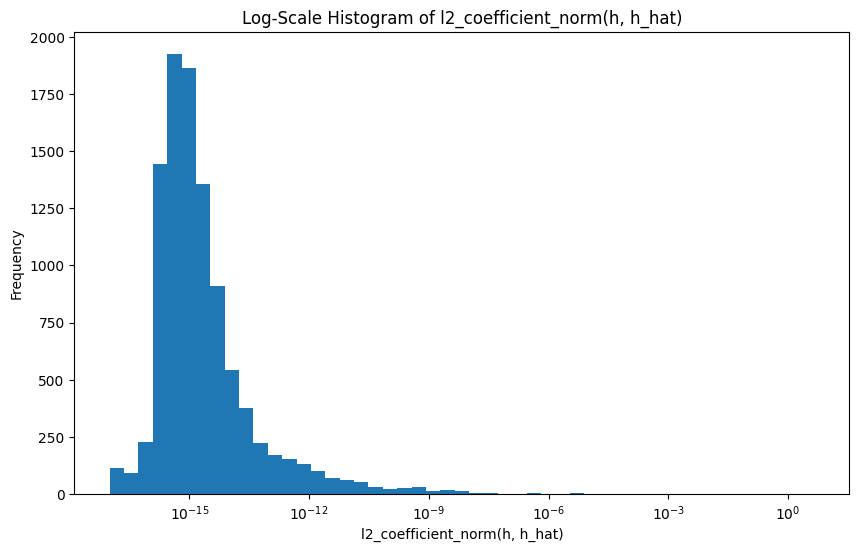

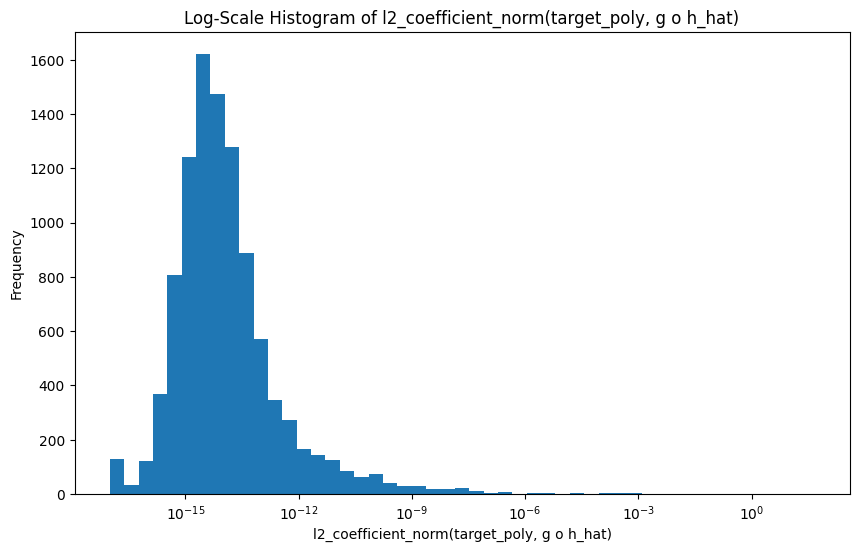

In [45]:
# Generate 1000 g, h, target_poly triplets
triplets = [new_poly(1.5) for _ in range(10000)]

# Calculate l2_coefficient_norm for each triplet
norms = []
target_norms = []
for g, h, target_poly in tqdm(triplets):
    h_hat = solve_for_h(g, target_poly)
    norm = l2_coefficient_norm(h, h_hat)
    norms.append(norm)
    target_norms.append(l2_coefficient_norm(target_poly, compose(g, h_hat)))

norms = np.array(norms) + 1e-17  # Add a small value to avoid log(0)
target_norms = np.array(target_norms) + 1e-17  # Add a small value to avoid log(0)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(norms, bins=np.logspace(np.log10(min(norms)), np.log10(max(norms)), 50))
plt.xscale('log')
plt.xlabel('l2_coefficient_norm(h, h_hat)')
plt.ylabel('Frequency')
plt.title('Log-Scale Histogram of l2_coefficient_norm(h, h_hat)')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(target_norms, bins=np.logspace(np.log10(min(target_norms)), np.log10(max(target_norms)), 50))
plt.xscale('log')
plt.xlabel('l2_coefficient_norm(target_poly, g o h_hat)')
plt.ylabel('Frequency')
plt.title('Log-Scale Histogram of l2_coefficient_norm(target_poly, g o h_hat)')
plt.show()

100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]


Average error: 227824.0673
Average time: 0.0267
Total time: 27.7841


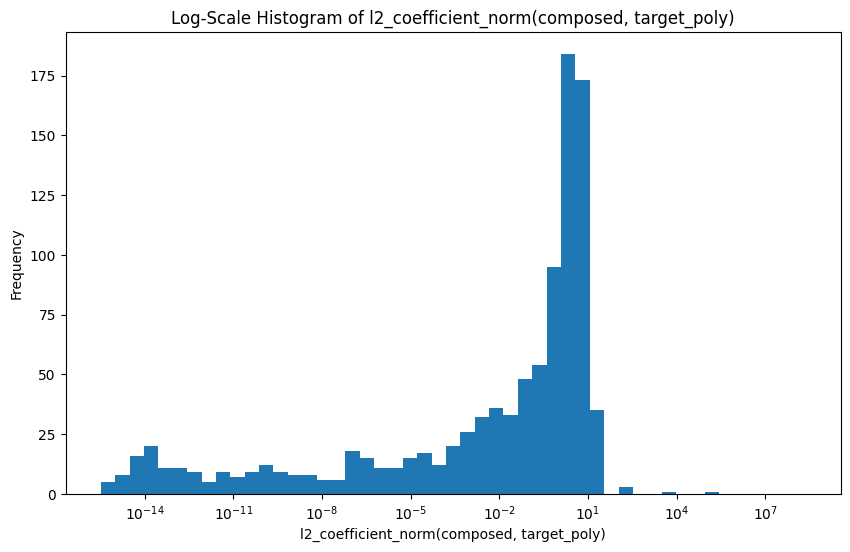

In [70]:
stats_10 = []
stats_10_time = []
start = time.time()
for i in tqdm(range(1000)):
    m, n = 4, 4
    width = 1.5
    g = Polynomial.Polynomial(np.random.uniform(-width, width, m))
    h = Polynomial.Polynomial(np.random.uniform(-width, width, n))
    target_poly = compose(g, h)

    g0 = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, m))
    h0 = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, n))

    s1 = time.time()
    h, g = carleman_upper_triangular_solver(g0, h0, target_poly, 10, verbose=False)
    stats_10_time.append(time.time() - s1)

    composed = compose(g, h)
    error = l2_coefficient_norm(composed, target_poly)
    stats_10.append(error)
print(f"Average error: {np.mean(stats_10):.4f}")
print(f"Average time: {np.mean(stats_10_time):.4f}")
print(f"Total time: {time.time() - start:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(stats_10, bins=np.logspace(np.log10(min(stats_10)), np.log10(max(stats_10)), 50))
plt.xscale('log')
plt.xlabel('l2_coefficient_norm(composed, target_poly)')
plt.ylabel('Frequency')
plt.title('Log-Scale Histogram of l2_coefficient_norm(composed, target_poly)')
plt.show()

# Chebychev

g: 0.0 - 3.0·x + 0.0·x² + 4.0·x³
h: 1.0 + 0.0·x - 8.0·x² + 0.0·x³ + 8.0·x⁴


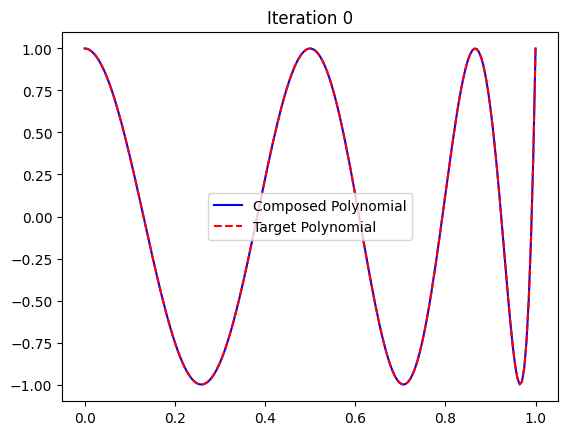

g: 1.49860178e-13 - 3.0·x + (6.93556323e-13)·x² + 4.0·x³
h: 1.0 + 0.0·x - 8.0·x² + 0.0·x³ + 8.0·x⁴


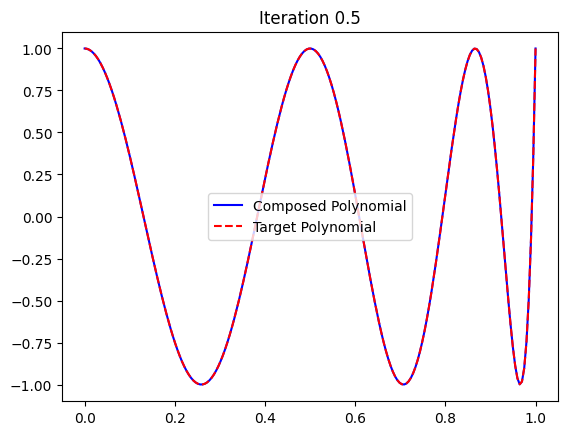

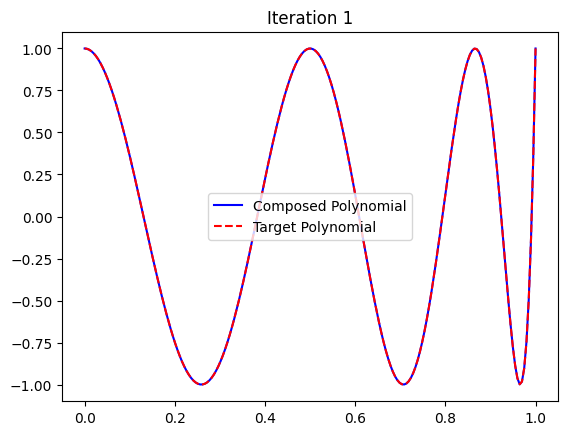

g: -1.56717588e-10 - 3.0·x - (5.33900701e-11)·x² + 4.0·x³
h: 1.0 + 0.0·x - 8.0·x² + 0.0·x³ + 8.0·x⁴


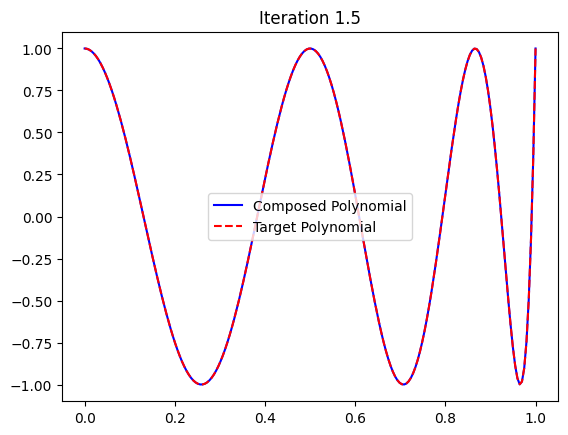

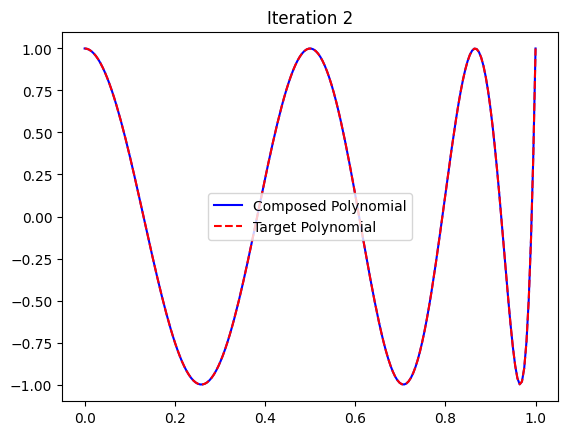

g: 3.79993329e-08 - 3.00000005·x + (1.34170465e-08)·x² + 4.0·x³
h: 1.0 + 0.0·x - 8.00000003·x² + 0.0·x³ + 7.99999943·x⁴


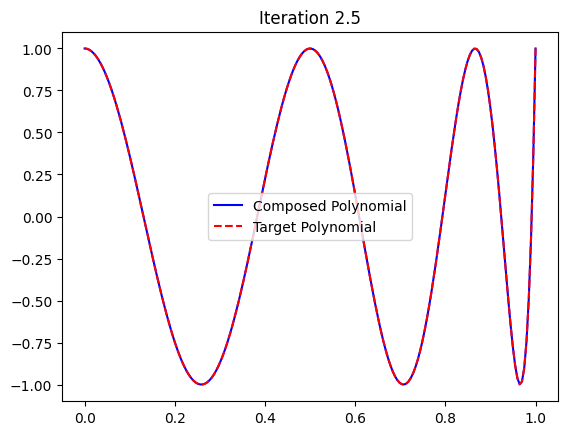

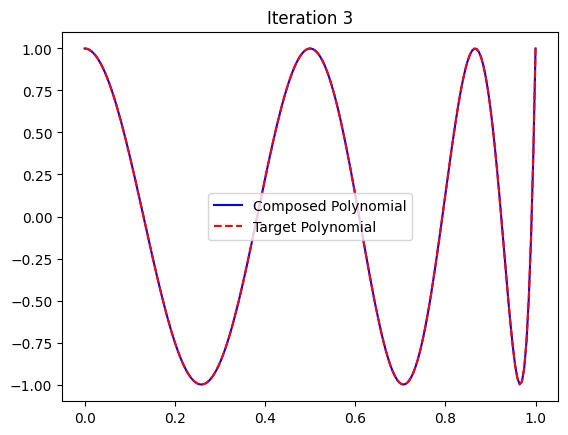

g: -9.25469391e-06 - 2.99998798·x - (3.26696237e-06)·x² + 4.00000051·x³
h: 1.0 + 0.0·x - 7.99999378·x² + 0.0·x³ + 8.00013895·x⁴


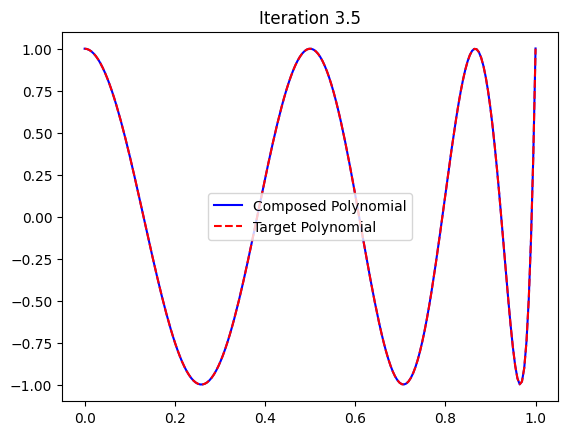

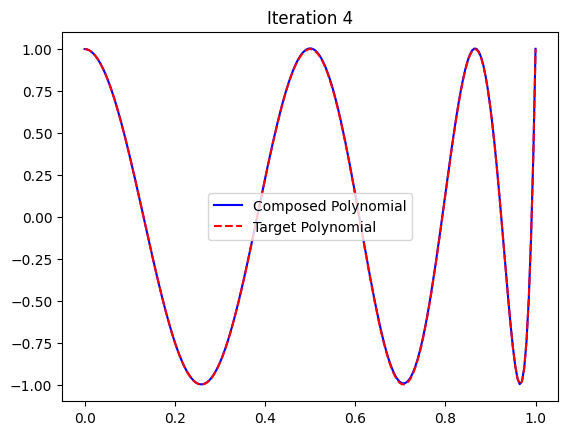

g: 0.00225384 - 3.0029263·x + 0.00079562·x² + 3.99987684·x³
h: 1.0 + 0.0·x - 8.00151544·x² + 0.0·x³ + 7.96614495·x⁴


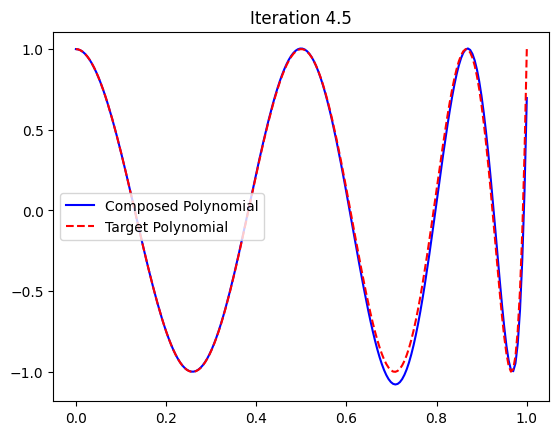

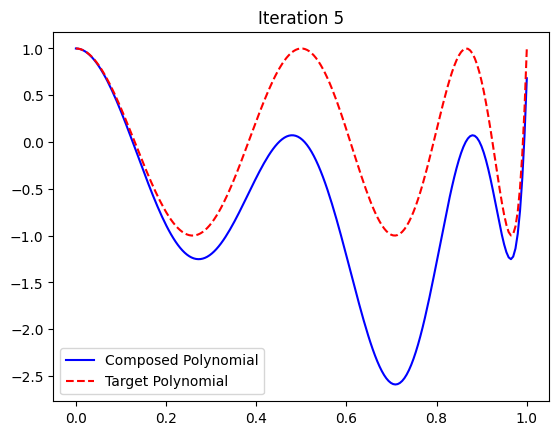

g: -0.55310359 - 2.28204101·x - 0.19499416·x² + 4.03013876·x³
h: 1.0 + 0.0·x - 7.64462114·x² + 0.0·x³ + 15.37723684·x⁴


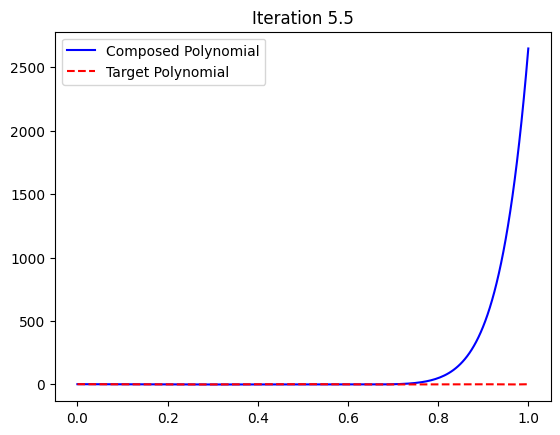

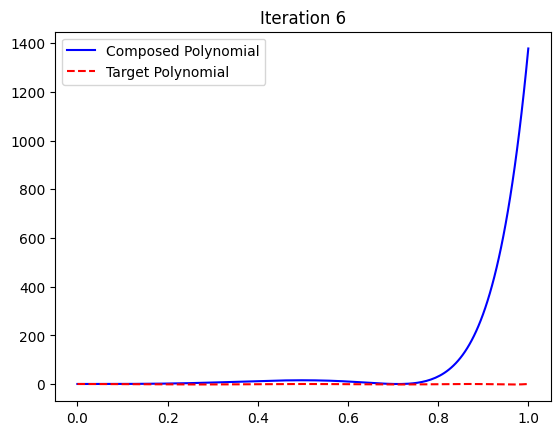

g: 17.7879647 - 30.49210138·x + 12.71881003·x² + 0.98532666·x³
h: -15.04098612 + 0.0·x - 0.28165037·x² + 0.0·x³ + 3.29577093·x⁴


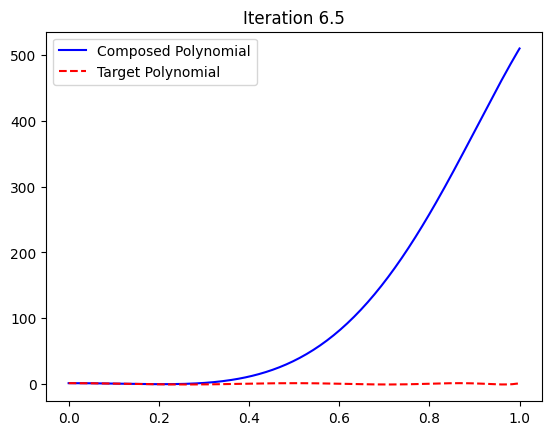

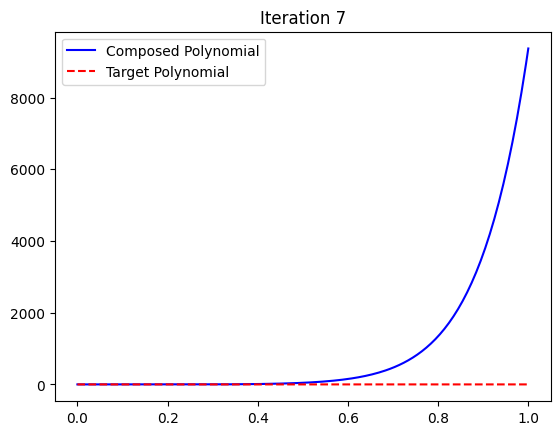

g: 476847.66892657 + 84608.36475935·x + 4942.90914935·x² + 94.77476633·x³
h: -15.04098612 + 0.0·x - 0.30131281·x² + 0.0·x³ + 3.26212429·x⁴


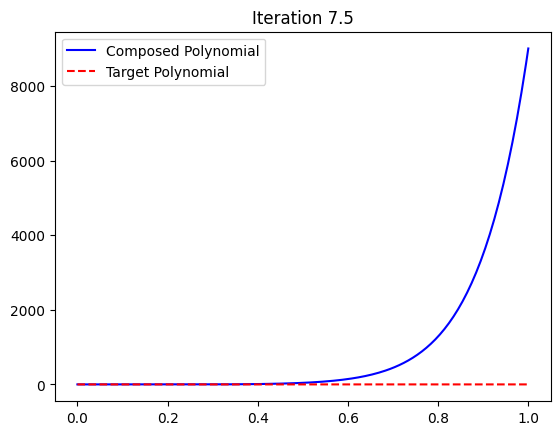

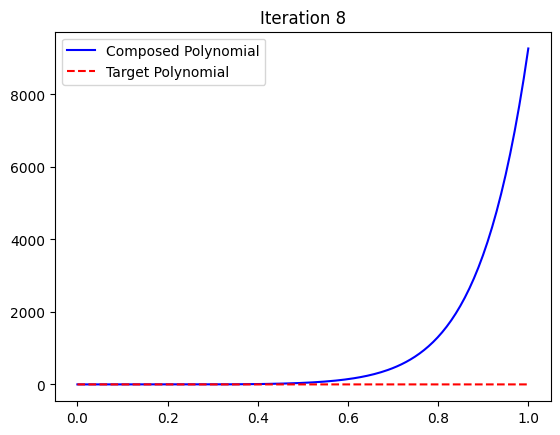

g: 498072.41404145 + 88635.75901321·x + 5196.95017167·x² + 100.10011549·x³
h: -15.04098612 + 0.0·x - 0.30179188·x² + 0.0·x³ + 3.26125635·x⁴


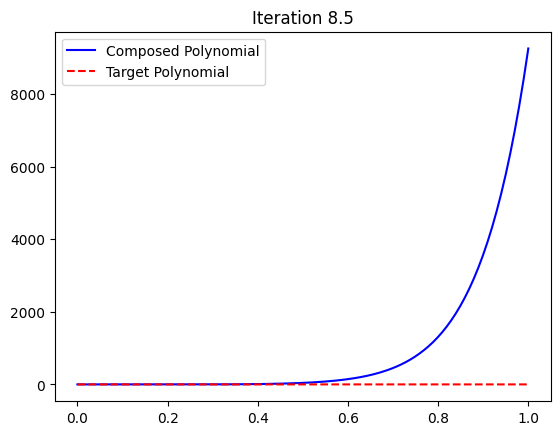

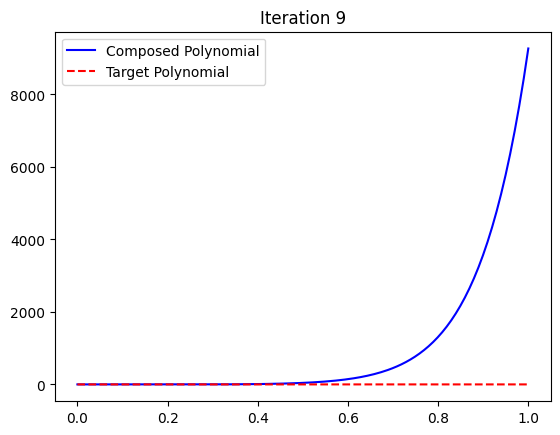

g: 498618.64122568 + 88739.38193339·x + 5203.48486649·x² + 100.23706053·x³
h: -15.04098612 + 0.0·x - 0.30180432·x² + 0.0·x³ + 3.26123378·x⁴


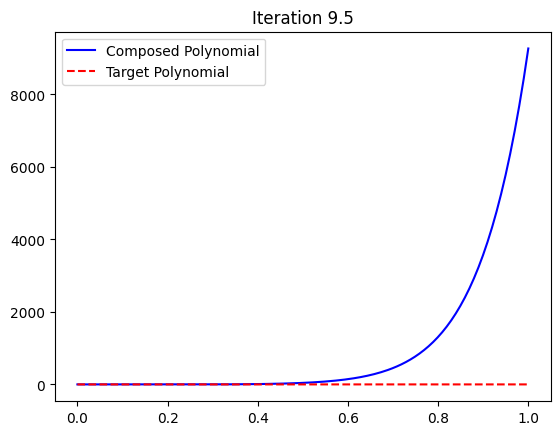

Polynomial([ 1.00000000e+00,  0.00000000e+00, -7.20000000e+01,  0.00000000e+00,
        8.40000000e+02,  0.00000000e+00, -1.34231040e+03,  0.00000000e+00,
        7.32680045e+03,  0.00000000e+00, -9.65247970e+02,  0.00000000e+00,
        3.47675524e+03], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

In [117]:
cheby_12 = Polynomial.Polynomial([1, 0, -72, 0, 840, 0, -3584, 0, 6912, 0, -6144, 0, 2048])
cheby_9 = Polynomial.Polynomial([0, 9, 0, -120, 0, 432, 0, -576, 0, 256])
cheby_3 = Polynomial.Polynomial([0, -3, 0, 4])
cheby_4 = Polynomial.Polynomial([1, 0, -8, 0, 8])
cheby_5 = Polynomial.Polynomial([0, 5, 0, -20, 0, 16])

cheby_25 = cheby_5(cheby_5)
# solve_for_h(cheby_3, cheby_12)

g = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, 4))
h = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, 4))
h, g = carleman_upper_triangular_solver(cheby_4, cheby_3, cheby_12, 10, 10, verbose=True)
compose(g, h)

In [48]:
def chebychev_solver(h, g, target_poly: Polynomial, iteration: int = 10, size: int = 10, w=None, verbose=False):
    if verbose:
        print(f"g: {g}")
        print(f"h: {h}")
    for i in range(iteration):
        m_h = carleman_matrix(h, len(g.coef), len(target_poly.coef)).T
        g = Polynomial.Polynomial(np.linalg.lstsq(
            m_h, target_poly.coef, rcond=None)[0])

        if verbose:
            composed = compose_layers([h, g])
            plot_polynomials(composed, target_poly, i+0.5)

        m_g = carleman_matrix(g, len(h.coef), len(target_poly.coef)).T
        h = Polynomial.Polynomial(np.linalg.lstsq(
            m_g, target_poly.coef, rcond=None)[0])

        if verbose:
            print(f"g: {g}")
            print(f"h: {h}")

            composed = compose(g, h)
            plot_polynomials(composed, target_poly, i, linspace_range=(0, 1))

    if verbose:
        print()
    return g, h

g: -0.02193861 - 0.27422672·x - 0.35500792·x² - 0.11003375·x³ - 0.31268946·x⁴
h: 0.10576616 + 0.26493372·x - 0.37153659·x² + 0.3595247·x³


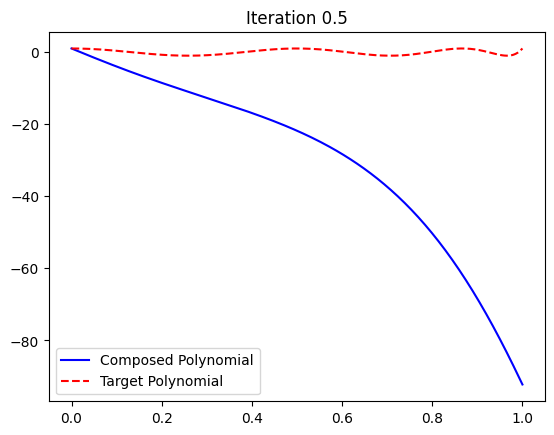

g: 11.11855336 + 1.56547864·x - 870.26369426·x² - 730.9548866·x³ +
2524.33980887·x⁴
h: -0.03953329 + 0.08535366·x + 0.00073048·x² + (1.60773207e-07)·x³


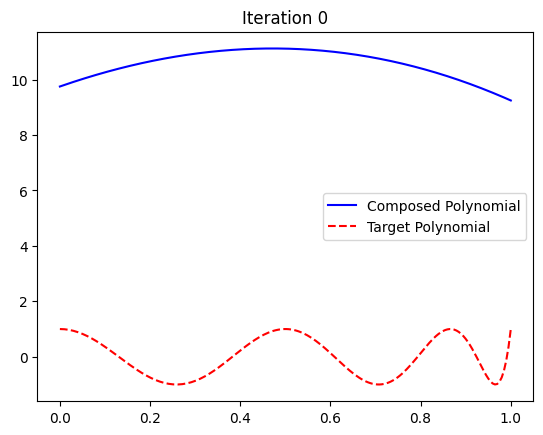

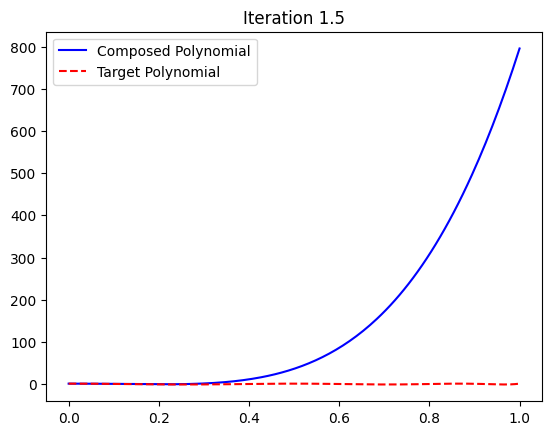

g: 24.22018392 + 3127.61160848·x + 138313.23123233·x² + 2497023.29910072·x³ +
15777519.30137954·x⁴
h: 4.92069396e-18 + (5.18429091e-05)·x + (2.46354789e-11)·x² +
(2.91379334e-19)·x³


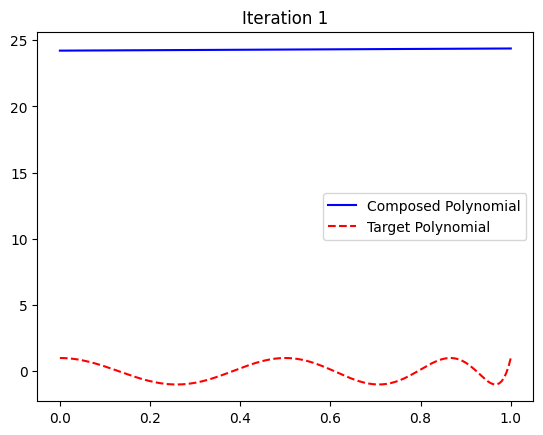

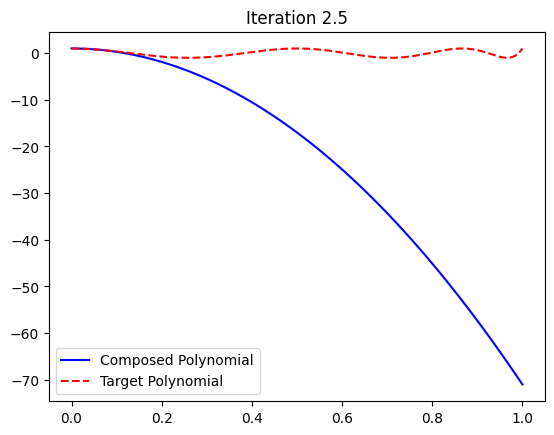

g: 1.0 + (2.63647758e-07)·x - (2.67888314e+10)·x² + (9.08526871e+09)·x³ +
0.67146002·x⁴
h: 6.18097922e-61 - (1.96046899e-25)·x + (4.67037649e-19)·x² +
(2.98603642e-29)·x³


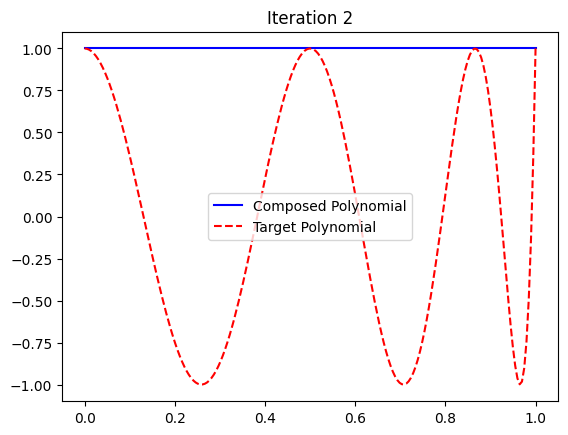

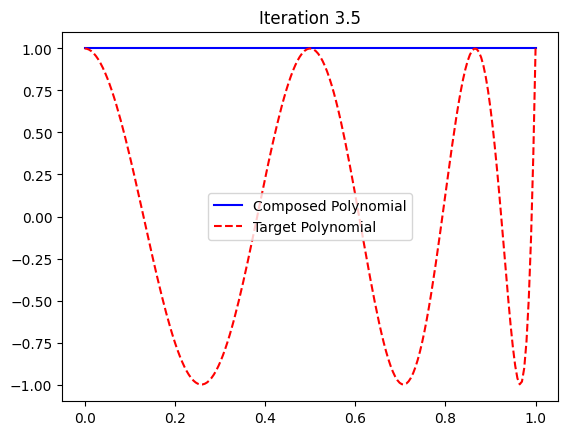

g: 1.0 + 0.0·x + 0.0·x² + 0.0·x³ + 0.0·x⁴
h: 0.25 + 0.25·x + 0.25·x² + 0.25·x³


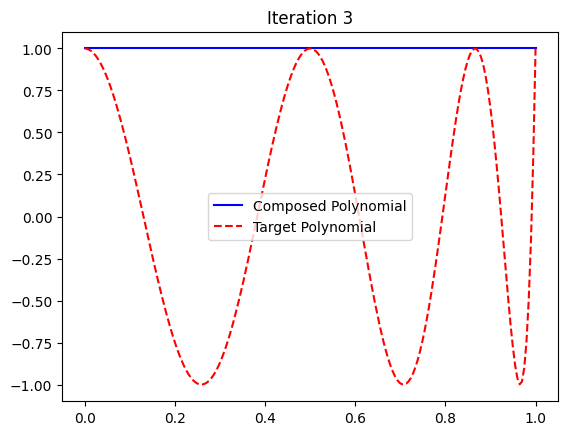

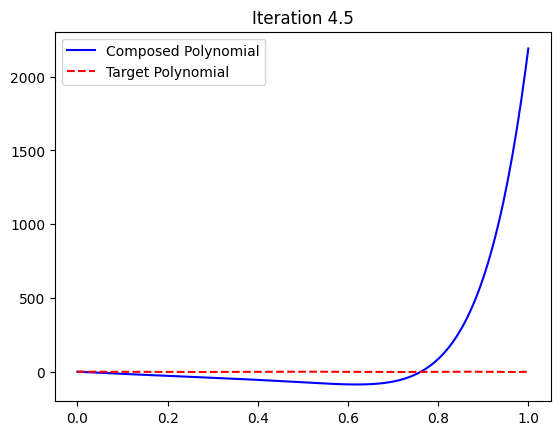

g: 621.97242739 - 5784.10437468·x + 20119.16577896·x² - 32641.92067026·x³ +
19874.76878552·x⁴
h: -8.78168271 + 0.01610213·x - (6.0712331e-07)·x² + (6.10321169e-12)·x³


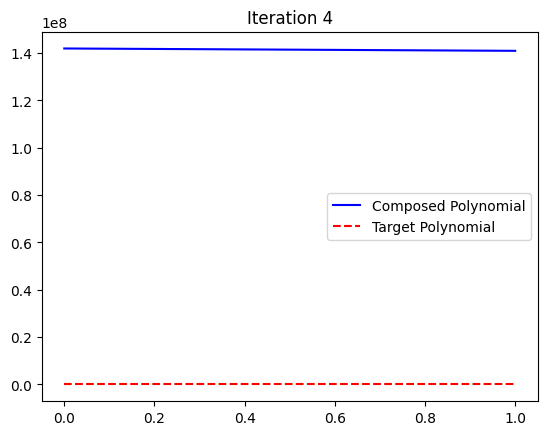

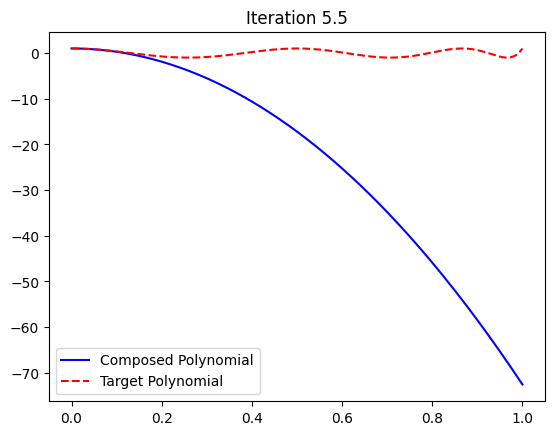

g: -13452932.04737621 + 27767939.7726999·x + 10255061.6445825·x² +
1175885.11921574·x³ + 44187.68929518·x⁴
h: 4.24258743e-29 - (3.98943802e-21)·x + (2.39133443e-13)·x² +
(8.17714005e-21)·x³


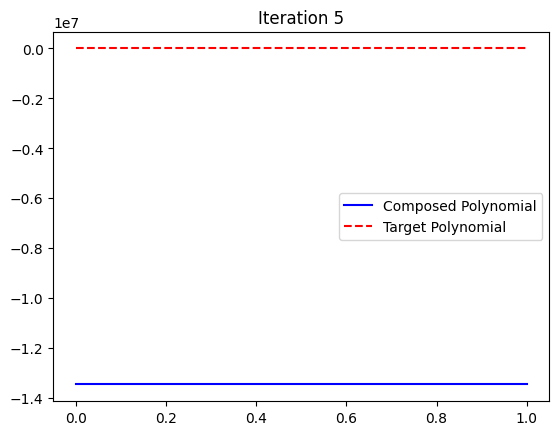

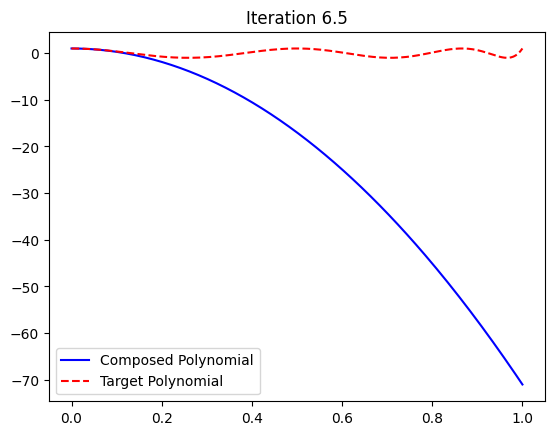

g: 1.0 - (3.01087122e+14)·x - (1.27738844e-14)·x² - (5.41943212e-43)·x³ -
(2.29924146e-71)·x⁴
h: 4.40888093e-44 - (2.69049305e-43)·x - (7.94233381e-28)·x² -
(2.01786979e-43)·x³


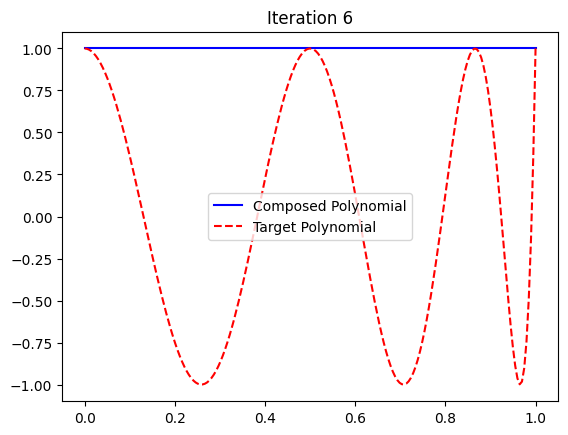

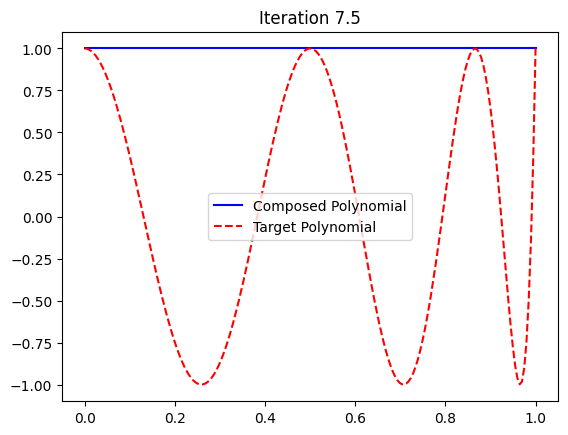

g: 1.0 + (4.40888093e-44)·x + (1.94382311e-87)·x² + (8.57008464e-131)·x³ +
(3.77844828e-174)·x⁴
h: 0.25 + 0.25·x + 0.25·x² + 0.25·x³


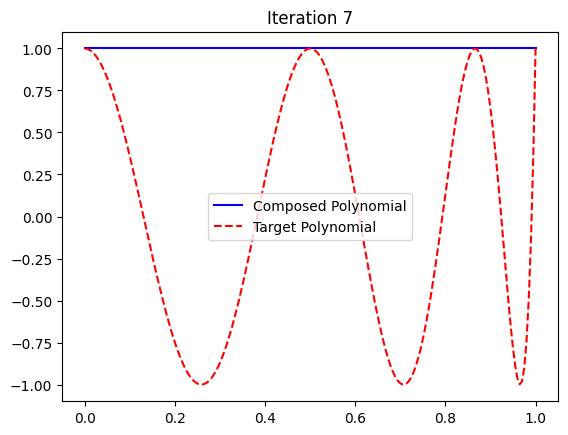

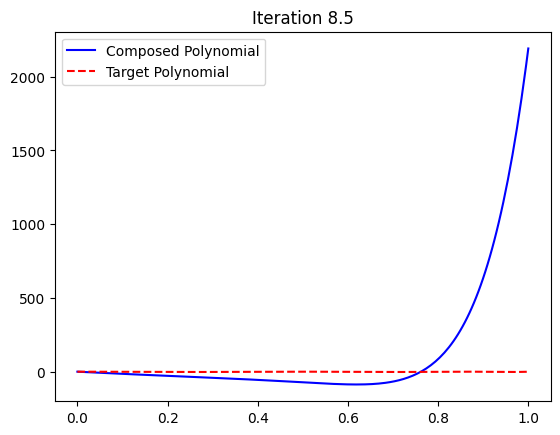

g: 621.97242739 - 5784.10437468·x + 20119.16577896·x² - 32641.92067026·x³ +
19874.76878552·x⁴
h: -8.78168271 + 0.01610213·x - (6.0712331e-07)·x² + (6.10321169e-12)·x³


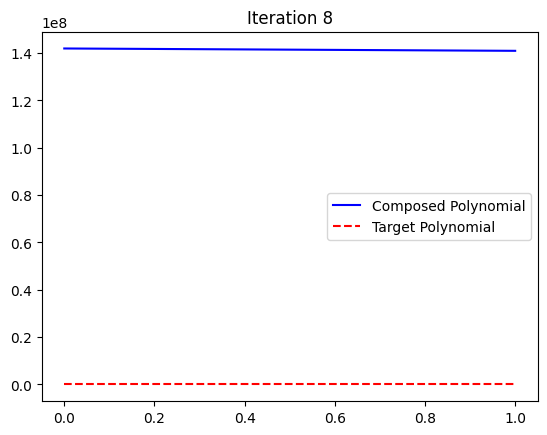

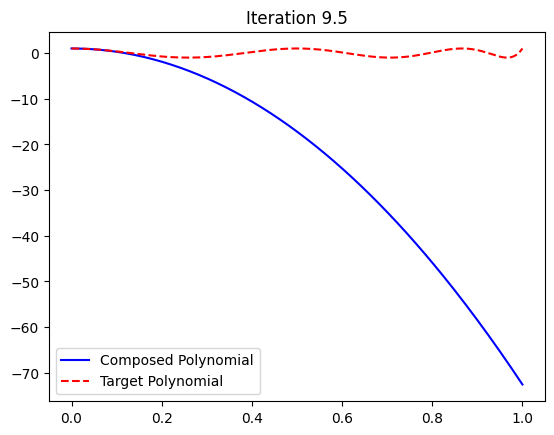

g: -13452932.0474649 + 27767939.7727462·x + 10255061.64465085·x² +
1175885.11922901·x³ + 44187.68929587·x⁴
h: 4.24258743e-29 - (3.98943802e-21)·x + (2.39133443e-13)·x² +
(8.17714005e-21)·x³


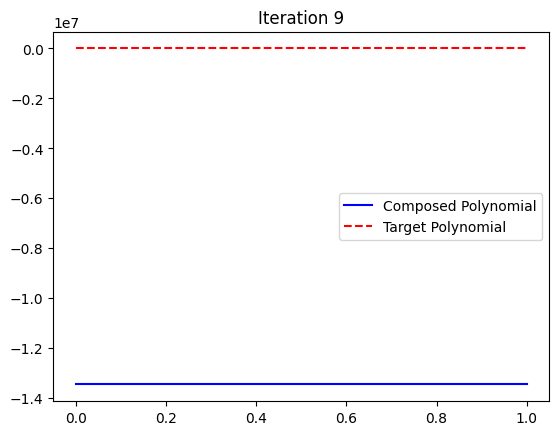

In [49]:
cheby_12 = Polynomial.Polynomial([1, 0, -72, 0, 840, 0, -3584, 0, 6912, 0, -6144, 0, 2048])
cheby_3 = Polynomial.Polynomial([0, -3, 0, 4])
cheby_4 = Polynomial.Polynomial([1, 0, -8, 0, 8])

# solve_for_h(cheby_3, cheby_12)

g = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, 4))
h = Polynomial.Polynomial(np.random.uniform(-0.5, 0.5, 5))
g, h = chebychev_solver(g, h, cheby_12, 10, 10, verbose=True)